Current conda env: `pyvista`

In this notebook:  
1. I import the data in two ways: netCDF4 OR rasterio  
2. Then I create a mesh using gemgis(geo data) and correct it with pyvista  
3. And render it wth pyvista.

Importantly - I compare the time and integrity of the two import methods. They perform the same and really fast (~10s for mesh creation of all time points).  
The mesh looks (by eye) similar to the mesh I created manually - while performance is much faster and at least by memory size in python are probably smaller (24MB vs 32MB for my obj file).

Thus, moving on, I chose netCDF4 just because it provides more metadata to rasterio (as far as I can tell).

In [1]:
import pyvista as pv
import numpy as np
import netCDF4 as nc
import vtk
import matplotlib.pyplot as plt
import gemgis as gg
import rasterio as rio

/home/ella/miniconda3/envs/pyvista/lib/python3.11/site-packages/gemgis/gemgis.py:27: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
#Environment Report for Reproducibilty

## Just some useful debugging info if you have any issues
pv.Report(["netCDF4", "tqdm"])

--------------------------------------------------------------------------------
  Date: Thu Dec 29 13:02:06 2022 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4
        GPU Vendor : Intel
      GPU Renderer : Mesa Intel(R) HD Graphics 620 (KBL GT2)
       GPU Version : 4.6 (Core Profile) Mesa 22.0.5

  Python 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC
  10.4.0]

           netCDF4 : 1.6.2
              tqdm : 4.64.1
           pyvista : 0.37.0
               vtk : 9.2.2
             numpy : 1.24.0
           imageio : 2.23.0
            scooby : 0.7.0
             pooch : v1.6.0
        matplotlib : 3.6.2
           IPython : 8.7.0
          colorcet : 3.0.1
           cmocean : 2.0
             scipy : 1.9.3
        jupyterlab : 3.5.2
--------------------------------------------------------------------------------

In [10]:
dataset_path = 'UFZ_RemoteSensing/HOLAPS-H-JJA_anomaly-d-2001-2005.nc'
heat_var = 'surface_upward_sensible_heat_flux'
fill_value=-999

# explore the dataset
with netCDF4

In [9]:
ds = nc.Dataset(dataset_path)
print(ds.variables.keys())

dict_keys(['time', 'longitude', 'latitude', 'surface_upward_sensible_heat_flux'])


In [4]:
keys = ['time', 'longitude', 'latitude', 'surface_upward_sensible_heat_flux']

In [5]:
## Print dimensions:
for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 460
<class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 1233
<class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 601


In [6]:
## get time, longitude, latitue datasets (all are 1D + metadata):
time = ds[keys[0]]     ## array holding the timestamps
lon = ds[keys[1]]     ## array holding the longitude positions on the world map
lat = ds[keys[2]]     ## array holding the latitude positions on the world map

## 3D - lon, lat, time
heat = ds[keys[3]]     ## the actual heat flux data matrix


In [7]:
## Print metadata:
print(time)
print('*'*80)
print(lon)
print('*'*80)
print(lat)
print('*'*80)
print(heat)
print('*'*80)

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: day as %Y%m%d.%f
    calendar: proleptic_gregorian
    axis: T
unlimited dimensions: time
current shape = (460,)
filling on, default _FillValue of 9.969209968386869e+36 used
********************************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (1233,)
filling on, default _FillValue of 9.969209968386869e+36 used
********************************************************************************
<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (601,)
filling on, default _FillValue of 9.969209968386869e+36 used
****************************************************

# Load the data & create a mesh
Possible with `netCDF4` or `rasterio`:  
netCDF4 is good for exploring the data, but the import method should be chosen by speed.  
mesh creation is with `gemgis` - creates a `pyvista.core.pointset.StructuredGrid`.  

Importantly - netCDF4 reads the array as a `numpy.ma` (masked array), and rasterio reads it as a normal numpy array.

side note: my manually created mesh .obj file is 32MB per time point.

### netCDF4

In [92]:
%%timeit
ds = nc.Dataset(dataset_path)

arr_shape = ds.variables[heat_var].shape

#load each timepoint:
for arr in ds[heat_var]:
    
    min_val = np.min(arr)
    
    grid = gg.visualization.create_dem_3d(dem=arr.filled(fill_value=fill_value), 
                                          extent=[0,arr_shape[2],0,arr_shape[1]])
    


/home/ella/miniconda3/envs/pyvista/lib/python3.11/site-packages/pyvista/utilities/helpers.py:507: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


10.6 s ± 1.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [93]:
### get info:
arr = ds[heat_var][0]
min_val = np.min(arr)
grid = gg.visualization.create_dem_3d(dem=arr.filled(fill_value=fill_value), 
                                      extent=[0,arr_shape[2],0,arr_shape[1]])

print(f'memory size: {grid.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB
grid

memory size: 11.31 MB


StructuredGrid (0x7fbbe30e3a60)
  N Cells:	739200
  N Points:	741033
  X Bounds:	0.000e+00, 1.232e+03
  Y Bounds:	0.000e+00, 6.000e+02
  Z Bounds:	-9.990e+02, 1.190e+02
  Dimensions:	601, 1233, 1
  N Arrays:	1

In [94]:
%%timeit
clipped = grid.threshold(int(min_val-2), invert=False, preference='point', all_scalars=True)

107 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
### get info:
clipped = grid.threshold(int(min_val-2), invert=False, preference='point', all_scalars=True)

print(f'memory size: {clipped.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB
clipped

memory size: 24.12 MB


UnstructuredGrid (0x7fbbe3195ba0)
  N Cells:	440957
  N Points:	450598
  X Bounds:	8.800e+01, 1.232e+03
  Y Bounds:	0.000e+00, 6.000e+02
  Z Bounds:	-1.110e+02, 1.190e+02
  N Arrays:	1

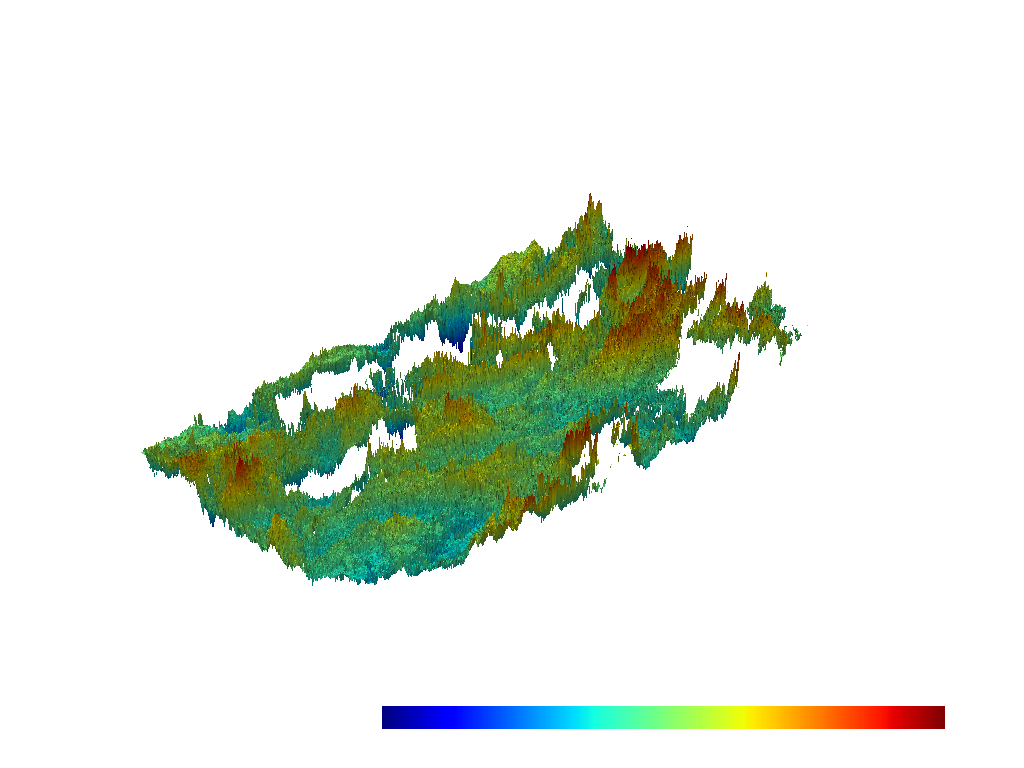

In [96]:
p = pv.Plotter()

p.add_mesh(mesh=clipped, cmap='jet')
###, scalars=grid["Elevation"], cmap='gist_earth')


# p.camera_position =[(-283.285811675846, -1597.1397046051004, 1155.542325449192),
#                     (577.9371599370799, 495.3480261506809, 381.7124055285182),
#                     (0.17313457304419916, 0.27814381639313923, 0.9448070898437746)]

#p.show_grid(color='black')
p.set_background(color='white')
p.show()

### Rasterio

In [98]:
## since it opens a normal numpy array (not masked), it's not as straight forward to get the min. Thus, i set min manually:
min_val = -1000

##### Option 1:

In [99]:
%%timeit

## just to get the shape:
ds = nc.Dataset(dataset_path)
arr_shape = ds.variables[heat_var].shape

with rio.open(f'netcdf:{dataset_path}:{heat_var}', 'r') as src:
    for i in range(src.count):
        arr = src.read(i+1)
        grid = gg.visualization.create_dem_3d(dem=arr, extent=[0,arr_shape[2],0,arr_shape[1]])

10.5 s ± 674 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Option 2:

In [100]:
%%timeit

## just to get the shape:
ds = nc.Dataset(dataset_path)
arr_shape = ds.variables[heat_var].shape

with rio.open(f'netcdf:{dataset_path}:{heat_var}', 'r') as src:
    for i in range(src.count):
        #arr = src.read(i+1)
        grid = gg.visualization.create_dem_3d(dem=src.read(i+1), extent=[0,arr_shape[2],0,arr_shape[1]])

10.4 s ± 552 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So both options are the same in run time (and actually similar to `netCDF4`).

In [101]:
### get info:
arr_shape = ds.variables[heat_var].shape

with rio.open(f'netcdf:{dataset_path}:{heat_var}', 'r') as src:
    for i in range(1):
        arr = src.read(i+1)
        
        grid = gg.visualization.create_dem_3d(dem=arr, extent=[0,arr_shape[2],0,arr_shape[1]])

print(f'memory size: {grid.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB
grid

memory size: 11.31 MB


StructuredGrid (0x7fbbe3857f40)
  N Cells:	739200
  N Points:	741033
  X Bounds:	0.000e+00, 1.232e+03
  Y Bounds:	0.000e+00, 6.000e+02
  Z Bounds:	-1.000e+07, 1.190e+02
  Dimensions:	601, 1233, 1
  N Arrays:	1

In [102]:
%%timeit
clipped = grid.threshold(int(min_val-2), invert=False, preference='point', all_scalars=True)

107 ms ± 7.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
### get info:
clipped = grid.threshold(int(min_val-2), invert=False, preference='point', all_scalars=True)

print(f'memory size: {clipped.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB
clipped

memory size: 24.12 MB


UnstructuredGrid (0x7fbbe3195d20)
  N Cells:	440957
  N Points:	450598
  X Bounds:	8.800e+01, 1.232e+03
  Y Bounds:	0.000e+00, 6.000e+02
  Z Bounds:	-1.110e+02, 1.190e+02
  N Arrays:	1

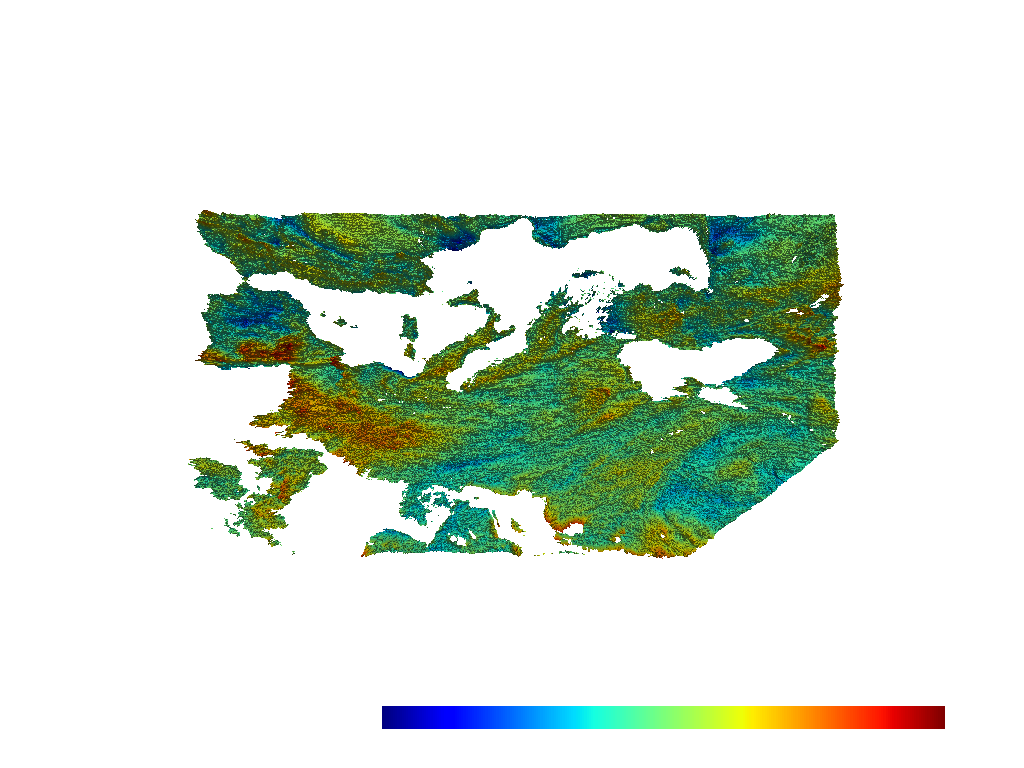

In [114]:
p = pv.Plotter()

p.add_mesh(mesh=clipped, cmap='jet')
###, scalars=grid["Elevation"], cmap='gist_earth')


# p.camera_position =[(-283.285811675846, -1597.1397046051004, 1155.542325449192),
#                     (577.9371599370799, 495.3480261506809, 381.7124055285182),
#                     (0.17313457304419916, 0.27814381639313923, 0.9448070898437746)]

p.camera_position = 'xy'

#p.show_grid(color='black')
p.set_background(color='white')
p.show()